# **Theme**:
#### Calculate purchase price for bonds (rank prices of bonds in descending order, identify suspected errors in data and offer remediation actions)

# Что от нас требуется:
По данному нам датасету рассмотреть цены каждого из активов, проанализировать их, отсортировать по убыванию цены, а также понять, есть ли в данной нам информации ошибки, и если есть, то попробовать их исправить.

# Базовые библиотеки и функции:

Для начала запишем стандартные библиотеки, которые будут использоваться нами, и подпишем, для чего они нужны. Также пропишем функции вычисления некоторых значений, которые будут использоваться нами чуть позже, и подтвердим примером, что они работают.

In [1]:
import pandas as pd # библиотека, необходимая нам для работы с таблицами вида xlsx (Excel-таблицы) и красивой визуализации таблиц
import seaborn as sns
import matplotlib.pyplot as plt # библиотека для визуализации данных, построения графиков

In [2]:
def AnnuallizerProfitability(arr):
    return arr[0]*arr[1] + (arr[1]-arr[2])/arr[3]

def BaseForAccruals(arr):
    return (arr[1]+arr[2])/2

def YTM(arr):
    return round(AnnuallizerProfitability(arr)/BaseForAccruals(arr), 4)

def PurchasePriceFromYTM(arr):
    return (arr[1]*(2+arr[0]*arr[3]-arr[2]*arr[3]))/(arr[2]*arr[3]+2)

print("Вычисленные значения для данного нам примера:")
test_case = [0.05, 10000, 10300, 3]
print(f"Annualized profitability: {AnnuallizerProfitability(test_case)}")
print(f"Base for accruals: {BaseForAccruals(test_case)}")
print(f"YTM: {YTM(test_case)*100}%")

Вычисленные значения для данного нам примера:
Annualized profitability: 400.0
Base for accruals: 10150.0
YTM: 3.94%


#Часть 1: Первый датасет

Необходимо сохранить саму таблицу и данные в ней. Заметим, что таблицу с данными мы чуть чуть поправили (так с ней горазо приятнее работать), у нас два листа с датой, соответственно сначала мы поработаем с листом *data_1*, потом с *data_2*.

In [3]:
table = pd.read_excel("NIS_data.xlsx", sheet_name="data_1")
table.head() # выведем таблицу чтоб увидеть, что она была правильно прочитана


,Unnamed: 0,Instrument 1,Instrument 2,Instrument 3,Instrument 4,Instrument 5,Instrument 6,Instrument 7,Instrument 8,Instrument 9,...,Instrument 11,Instrument 12,Instrument 13,Instrument 14,Instrument 15,Instrument 16,Instrument 17,Instrument 18,Instrument 19,Instrument 20
0,C= coupon rate,0.08,0.06,0.06,0.05,0.07,0.05,0.09,0.07,0.09,...,0.08,0.06,0.08,0.09,0.07,0.1,0.1,0.05,0.09,0.08
1,N = face value or nominal,11632.00,13183.00,11571.00,11914.00,10708.00,12.00,14004.00,11097.00,14470.00,...,10237.00,10586.00,11721.00,12345.00,13852.00,14411.0,14036.0,12246.00,11620.00,12763.00
2,PP = purchase price,12799.00,11667.00,10786.00,13089.00,13518.00,10199.00,13519.00,13801.00,11853.00,...,12792.00,10884.00,11714.00,12987.00,13055.00,11347.0,12020.0,12777.00,11185.00,14949.00
3,T = years to maturity,5.00,9.00,8.00,7.00,7.00,10.00,10.00,9.00,7.00,...,6.00,6.00,8.00,9.00,5.00,9.0,9.0,10.00,10.00,7.00


##Работа с неотсортированной таблицей


###Сохранение таблицы в удобный контейнер

Сохраним данную табличку в массив, с которым нам было бы удобнее работать. Для этого используем стандартный контейнер *словарь*, который позволяет удобно работать с инструментами как ключами словаря, и массивом из *C, N, PP, T* как значениями словаря)

In [4]:
working_table = table.reset_index(drop=True)  # убираем строку с инструментами для простоты работы
working_table = working_table.transpose() # переворачиваем датафрейм
working_table.columns = working_table.iloc[0]
working_table = working_table[1:]

working_dict = {}
for i in range(20):
    working_dict[working_table.index.to_list()[i]] =  working_table.iloc[i].to_list()

display(pd.DataFrame(working_dict).rename(index={0:'C', 1: 'N', 2:'PP', 3:'T'}))

,Instrument 1,Instrument 2,Instrument 3,Instrument 4,Instrument 5,Instrument 6,Instrument 7,Instrument 8,Instrument 9,Instrument 10,Instrument 11,Instrument 12,Instrument 13,Instrument 14,Instrument 15,Instrument 16,Instrument 17,Instrument 18,Instrument 19,Instrument 20
C,0.08,0.06,0.06,0.05,0.07,0.05,0.09,0.07,0.09,0.09,0.08,0.06,0.08,0.09,0.07,0.1,0.1,0.05,0.09,0.08
N,11632.00,13183.00,11571.00,11914.00,10708.00,12.00,14004.00,11097.00,14470.00,13637.00,10237.00,10586.00,11721.00,12345.00,13852.00,14411.0,14036.0,12246.00,11620.00,12763.00
PP,12799.00,11667.00,10786.00,13089.00,13518.00,10199.00,13519.00,13801.00,11853.00,11591.00,12792.00,10884.00,11714.00,12987.00,13055.00,11347.0,12020.0,12777.00,11185.00,14949.00
T,5.00,9.00,8.00,7.00,7.00,10.00,10.00,9.00,7.00,5.00,6.00,6.00,8.00,9.00,5.00,9.0,9.0,10.00,10.00,7.00


###Построение графика выбросов

Мы получили словарь, в котором хранятся наш инструменты их значения(*coupon rate*, *face value or nominal*, *purchase price*, *years to maturity*). Теперь нарисуем график и посмотрим, нет ли на графике "выбросов", т.е. точек, которые сильно выбиваются из общего множества точек.

P.S. на графике числа обозначают номер инструмента



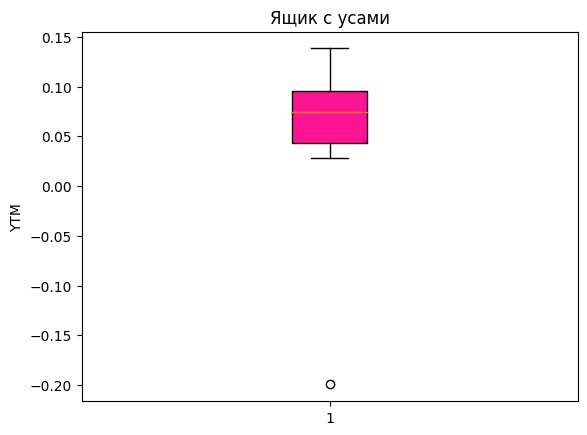

In [5]:
data = [YTM(working_dict[i]) for i in working_dict]
box=plt.boxplot(data,patch_artist=True)
colors = ['deeppink']

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.ylabel('YTM')
plt.title('Ящик с усами')
plt.show()

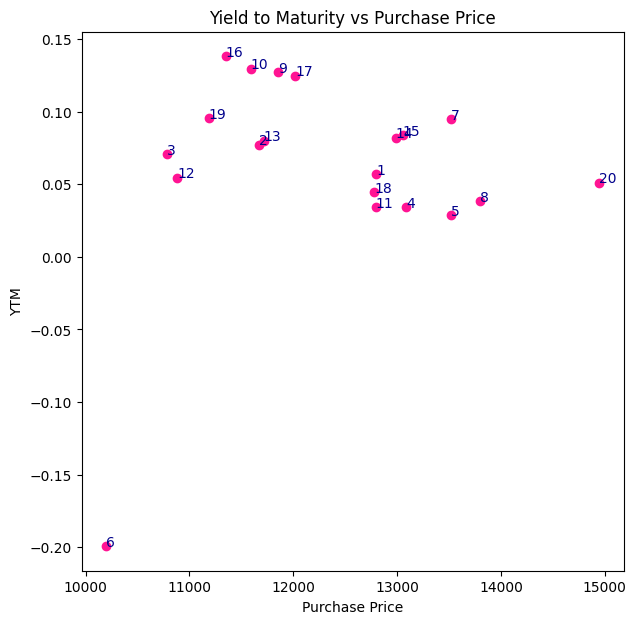

In [6]:
purchase_prices = [working_dict[i][2] for i in working_dict]
ytms = [YTM(working_dict[i]) for i in working_dict]
plt.figure(figsize=(7,7))
plt.scatter(purchase_prices, ytms, marker='o', linestyle='-', color = 'deeppink')

for i, txt in enumerate(working_dict.keys()):
    plt.text(purchase_prices[i], ytms[i], i+1, fontsize=10, color = 'darkblue')

plt.xlabel('Purchase Price')
plt.ylabel('YTM')
plt.title('Yield to Maturity vs Purchase Price')

plt.show()

####**Выводы**

Заметим, что большинство точек по YTM $\in(0, 0.15)$ (т.е. лежат в промежутке от 0 до 0.15), но есть точка под номером *6*, которая выбивается из этого промежутка. Это и есть наш "выброс", соотвественно мы можем сделать вывод, что у нас есть *ошибка в датасете*, и эта ошибка - инструмент №6, у которого аномально маленькая *face value of nominal*, (если по простому, то стоимость ценной бумаги), соотвественно она не принесет почти никакой прибыли и мы будем нести одни издержки при ее покупке.

####**Возможное решение данной проблемы:**


In [7]:
del working_dict['Instrument 6']

##Работа с отсортированной таблицей

### Сортировка 👼

Теперь нам нужно отсортировать наши инструменты по значению PP(*Purchase Price*). Сохраним отсортированный словарь в новый словарь (для удобства работы)

In [8]:
sorted_dict = dict(sorted(working_dict.items(), key=lambda item: item[1][2], reverse=True))
display(pd.DataFrame(sorted_dict).rename(index={0:'C', 1: 'N', 2:'PP', 3:'T'}))

,Instrument 20,Instrument 8,Instrument 7,Instrument 5,Instrument 4,Instrument 15,Instrument 14,Instrument 1,Instrument 11,Instrument 18,Instrument 17,Instrument 9,Instrument 13,Instrument 2,Instrument 10,Instrument 16,Instrument 19,Instrument 12,Instrument 3
C,0.08,0.07,0.09,0.07,0.05,0.07,0.09,0.08,0.08,0.05,0.1,0.09,0.08,0.06,0.09,0.1,0.09,0.06,0.06
N,12763.00,11097.00,14004.00,10708.00,11914.00,13852.00,12345.00,11632.00,10237.00,12246.00,14036.0,14470.00,11721.00,13183.00,13637.00,14411.0,11620.00,10586.00,11571.00
PP,14949.00,13801.00,13519.00,13518.00,13089.00,13055.00,12987.00,12799.00,12792.00,12777.00,12020.0,11853.00,11714.00,11667.00,11591.00,11347.0,11185.00,10884.00,10786.00
T,7.00,9.00,10.00,7.00,7.00,5.00,9.00,5.00,6.00,10.00,9.0,7.00,8.00,9.00,5.00,9.0,10.00,6.00,8.00


###Вычисление требуемых значений для отсортированной таблицы

Теперь вычислим эти значения для каждого из инструментов из отсортированного словаря и запишем в еще один словарь)

In [9]:
values_dict = {}
for i in sorted_dict:
    values_dict[i] = [AnnuallizerProfitability(sorted_dict[i]), BaseForAccruals(sorted_dict[i]), YTM(sorted_dict[i])]

display(pd.DataFrame(values_dict).rename(index={0:'Annualized profitability', 1: 'Base for accruals', 2:'YTM'}))

,Instrument 20,Instrument 8,Instrument 7,Instrument 5,Instrument 4,Instrument 15,Instrument 14,Instrument 1,Instrument 11,Instrument 18,Instrument 17,Instrument 9,Instrument 13,Instrument 2,Instrument 10,Instrument 16,Instrument 19,Instrument 12,Instrument 3
Annualized profitability,708.754286,476.345556,1308.8600,348.131429,427.842857,1129.0400,1039.716667,697.1600,393.126667,559.2000,1627.6000,1676.157143,938.5550,959.424444,1636.5300,1781.544444,1089.3000,585.493333,792.3850
Base for accruals,13856.000000,12449.000000,13761.5000,12113.000000,12501.500000,13453.5000,12666.000000,12215.5000,11514.500000,12511.5000,13028.0000,13161.500000,11717.5000,12425.000000,12614.0000,12879.000000,11402.5000,10735.000000,11178.5000
YTM,0.051200,0.038300,0.0951,0.028700,0.034200,0.0839,0.082100,0.0571,0.034100,0.0447,0.1249,0.127400,0.0801,0.077200,0.1297,0.138300,0.0955,0.054500,0.0709


Можно заметить, что словарь был отсортирован по цене покупки, однако сортировка по цене покупки не гарантируен большую прибыль при покупке данной ценной бумаги.
Соотвественно, для того, чтобы получить максимально возможную прибыль от покупки ценной бумаги, мы отсортируем словарь со значениями *Annualized profitability*, *Base for accruals* и *YTM* по значению *Annualized profitability*, так мы поймем, какие из ценных бумаг в год дают наибольшую сумму денег.

In [10]:
sorted_values_dict = dict(sorted(values_dict.items(), key=lambda item: item[1][0], reverse=True))
display(pd.DataFrame(sorted_values_dict).rename(index={0:'Annualized profitability', 1: 'Base for accruals', 2:'YTM'}))

,Instrument 16,Instrument 9,Instrument 10,Instrument 17,Instrument 7,Instrument 15,Instrument 19,Instrument 14,Instrument 2,Instrument 13,Instrument 3,Instrument 20,Instrument 1,Instrument 12,Instrument 18,Instrument 8,Instrument 4,Instrument 11,Instrument 5
Annualized profitability,1781.544444,1676.157143,1636.5300,1627.6000,1308.8600,1129.0400,1089.3000,1039.716667,959.424444,938.5550,792.3850,708.754286,697.1600,585.493333,559.2000,476.345556,427.842857,393.126667,348.131429
Base for accruals,12879.000000,13161.500000,12614.0000,13028.0000,13761.5000,13453.5000,11402.5000,12666.000000,12425.000000,11717.5000,11178.5000,13856.000000,12215.5000,10735.000000,12511.5000,12449.000000,12501.500000,11514.500000,12113.000000
YTM,0.138300,0.127400,0.1297,0.1249,0.0951,0.0839,0.0955,0.082100,0.077200,0.0801,0.0709,0.051200,0.0571,0.054500,0.0447,0.038300,0.034200,0.034100,0.028700


Таким образом мы можем заметить, что, с точки зрения получения ежегодной прибыли, наиболее профитным будет инструмент *16*, также инструменты *9, 10, 17 и 7* тоже неплохи. Остальные же дают меньше годовой прибыли, но тоже являются неплохими ценными бумагами.

##Выводы

Суммаризируя все сказанное выше, мы можем сказать что:
* Инструмент *6* является "выбросом", так как его значение *face value of nominal* слишком мало => инструмент является ошибкой в датасете.
* Наиболее профитный с точки зрения ежегодной прибыли инструмент - *№16*, все остальные инструмены так или иначе дают меньше прибыли каждый год (это не значит, что они менее прибыльные в целом)

#Часть 2: Второй Датасет

Сохраним второй датасет по аналогии с первым с помощью *numpy.read_excel*.

In [11]:
table2 = pd.read_excel("NIS_data.xlsx", sheet_name="data_2")
table2.head() # выведем таблицу чтоб увидеть. что она правильно прочиталась

,Unnamed: 0,Instrument 1,Instrument 2,Instrument 3,Instrument 4,Instrument 5,Instrument 6,Instrument 7,Instrument 8,Instrument 9,...,Instrument 11,Instrument 12,Instrument 13,Instrument 14,Instrument 15,Instrument 16,Instrument 17,Instrument 18,Instrument 19,Instrument 20
0,C= coupon rate,0.08,0.06,0.06,0.05,0.07,0.05,0.09,0.07,0.09,...,0.08,0.06,0.08,0.09,0.07,0.10,0.10,1.50,0.09,0.08
1,N = face value or nominal,11632.00,13183.00,11571.00,11914.00,10708.00,11014.00,14004.00,11097.00,14470.00,...,10237.00,10586.00,11721,12345.00,13852.00,14411.00,14036.00,12246.00,11620.00,12763.00
2,YTM,0.04,0.05,0.04,0.07,0.03,0.07,0.06,0.04,0.04,...,0.05,0.03,sdfsd,0.04,0.07,0.04,0.06,0.03,0.03,0.07
3,T = years to maturity,5.00,9.00,8.00,7.00,7.00,10.00,10.00,9.00,7.00,...,6.00,6.00,8,9.00,5.00,9.00,9.00,10.00,10.00,7.00


Теперь мы можем увидеть, что в нем отсутствует PP(*purchase price*), однако присутствует YTL, который расчитывается через PP. Из: $$ YTM = \frac{C \cdot N + (\frac{N-PP}{T})}{\frac{N+PP}{2}} $$ Следует:
$$PP = \frac{N \cdot (2+C\cdot T - YTM \cdot T)}{YTM \cdot T+2}$$

Из этого следует функция выше (В списке функций).

## Работа с неотсортированной таблицей

###Сохранение таблицы в удобный контейнер

Здесь опять сохраним значения из таблицы в удобный словарь.

In [12]:
working_table2 = table2.reset_index(drop=True)  # убираем строку с инструментами для простоты работы
working_table2 = working_table2.transpose() # переворачиваем датафрейм
working_table2.columns = working_table2.iloc[0]
working_table2 = working_table2[1:]

working_dict2 = {}
for i in range(20):
    working_dict2[working_table2.index.to_list()[i]] =  working_table2.iloc[i].to_list()

display(pd.DataFrame(working_dict2).rename(index={0:'C', 1: 'N', 2:'YTM', 3:'T'}))

,Instrument 1,Instrument 2,Instrument 3,Instrument 4,Instrument 5,Instrument 6,Instrument 7,Instrument 8,Instrument 9,Instrument 10,Instrument 11,Instrument 12,Instrument 13,Instrument 14,Instrument 15,Instrument 16,Instrument 17,Instrument 18,Instrument 19,Instrument 20
C,0.08,0.06,0.06,0.05,0.07,0.05,0.09,0.07,0.09,0.09,0.08,0.06,0.08,0.09,0.07,0.10,0.10,1.50,0.09,0.08
N,11632.00,13183.00,11571.00,11914.00,10708.00,11014.00,14004.00,11097.00,14470.00,13637.00,10237.00,10586.00,11721,12345.00,13852.00,14411.00,14036.00,12246.00,11620.00,12763.00
YTM,0.04,0.05,0.04,0.07,0.03,0.07,0.06,0.04,0.04,0.05,0.05,0.03,sdfsd,0.04,0.07,0.04,0.06,0.03,0.03,0.07
T,5.00,9.00,8.00,7.00,7.00,10.00,10.00,9.00,7.00,5.00,6.00,6.00,8,9.00,5.00,9.00,9.00,10.00,10.00,7.00


Даже без построения графика выбросов можно увидеть, что один из инструментов является даже не выбросом, а просто ошибкой в датасете - это инструмент *13*. Удалим его сразу, по аналогичным с *Частью 1* соображениям, для того, чтоб избежать ошибок при работе с данными.

In [13]:
del working_dict2['Instrument 13']
display(pd.DataFrame(working_dict2).rename(index={0:'C', 1: 'N', 2:'YTM', 3:'T'}))

,Instrument 1,Instrument 2,Instrument 3,Instrument 4,Instrument 5,Instrument 6,Instrument 7,Instrument 8,Instrument 9,Instrument 10,Instrument 11,Instrument 12,Instrument 14,Instrument 15,Instrument 16,Instrument 17,Instrument 18,Instrument 19,Instrument 20
C,0.08,0.06,0.06,0.05,0.07,0.05,0.09,0.07,0.09,0.09,0.08,0.06,0.09,0.07,0.10,0.10,1.50,0.09,0.08
N,11632.00,13183.00,11571.00,11914.00,10708.00,11014.00,14004.00,11097.00,14470.00,13637.00,10237.00,10586.00,12345.00,13852.00,14411.00,14036.00,12246.00,11620.00,12763.00
YTM,0.04,0.05,0.04,0.07,0.03,0.07,0.06,0.04,0.04,0.05,0.05,0.03,0.04,0.07,0.04,0.06,0.03,0.03,0.07
T,5.00,9.00,8.00,7.00,7.00,10.00,10.00,9.00,7.00,5.00,6.00,6.00,9.00,5.00,9.00,9.00,10.00,10.00,7.00


### Построение графика выбросов

Аналогично первой части построим график. Напомним, что выброс - точка, которая сильно выбивается из общего множества точек

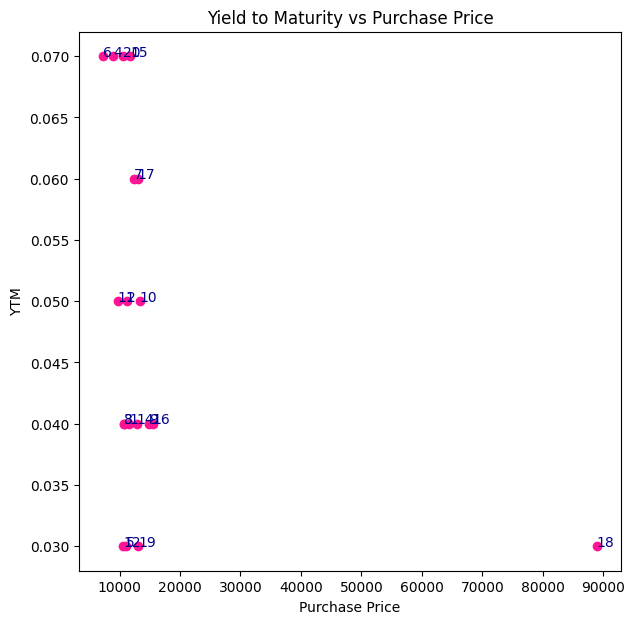

In [14]:
ytms2 = [working_dict2[i][2] for i in working_dict2]
purchase_prices2 = [PurchasePriceFromYTM(working_dict2[i]) for i in working_dict2]
plt.figure(figsize=(7,7))
plt.scatter(purchase_prices2, ytms2, marker='o', linestyle='-', color = 'deeppink')

for i, txt in enumerate(working_dict2.keys()):
  if (i>=12):
      plt.text(purchase_prices2[i], ytms2[i], i+2, fontsize=10, color = 'darkblue')
  else:
      plt.text(purchase_prices2[i], ytms2[i], i+1, fontsize=10, color = 'darkblue')

plt.xlabel('Purchase Price')
plt.ylabel('YTM')
plt.title('Yield to Maturity vs Purchase Price')

plt.show()

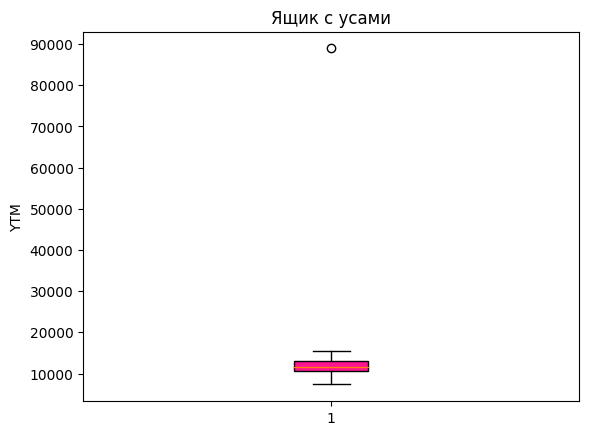

In [15]:
data = [PurchasePriceFromYTM(working_dict2[i]) for i in working_dict2]
box=plt.boxplot(data,patch_artist=True)
colors = ['deeppink']

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.ylabel('YTM')
plt.title('Ящик с усами')
plt.show()

Здесь можно заметить уже немного другую ситуацию: большинство точек лежит в промежутке PP(*purchase price*) $ \in (10000, 20000)$, однако есть точка, которая выбивается из этого промежутка и лежит в промежутке PP $\in (80000, 90000)$. Эта точка - инструмент *18*. Такое произошло из-за аномально высокого значения C, что привело к огромному значению PP при его вычислении.

####**Возможное решение данной проблемы:**
Исключение данной точки из датасета по аналогичным с *Частью 1* причинам.

In [16]:
del working_dict2['Instrument 18']

##Работа с отсортированной таблицей

###Сортировка таблицы 😀

Поступим аналогично *Части 1*: Отсортируем наш изначальный словарь по PP(*purchase price*).

In [17]:
sorted_dict2 = dict(sorted(working_dict2.items(), key=lambda item: PurchasePriceFromYTM(item[1]), reverse=True))
display(pd.DataFrame(sorted_dict2).rename(index={0:'C', 1: 'N', 2:'YTM', 3:'T'}))

,Instrument 16,Instrument 9,Instrument 10,Instrument 19,Instrument 17,Instrument 14,Instrument 7,Instrument 15,Instrument 1,Instrument 2,Instrument 5,Instrument 3,Instrument 8,Instrument 20,Instrument 12,Instrument 11,Instrument 4,Instrument 6
C,0.10,0.09,0.09,0.09,0.10,0.09,0.09,0.07,0.08,0.06,0.07,0.06,0.07,0.08,0.06,0.08,0.05,0.05
N,14411.00,14470.00,13637.00,11620.00,14036.00,12345.00,14004.00,13852.00,11632.00,13183.00,10708.00,11571.00,11097.00,12763.00,10586.00,10237.00,11914.00,11014.00
YTM,0.04,0.04,0.05,0.03,0.06,0.04,0.06,0.07,0.04,0.05,0.03,0.04,0.04,0.07,0.03,0.05,0.07,0.07
T,9.00,7.00,5.00,10.00,9.00,9.00,10.00,5.00,5.00,9.00,7.00,8.00,9.00,7.00,6.00,6.00,7.00,10.00


###Вычисление требуемых значений для отсортированной таблицы

Теперь создадим новый словарь, содержащий значения *Annualized profitability*, *Base for accruals* и *YTM*.

In [18]:
values_dict2 = {}
for i in sorted_dict2:
    first_like_arr = [sorted_dict2[i][0], sorted_dict2[i][1], PurchasePriceFromYTM(sorted_dict2[i]),  sorted_dict2[i][3]]
    values_dict2[i] = [AnnuallizerProfitability(first_like_arr), BaseForAccruals(first_like_arr), sorted_dict2[i][2]]

display(pd.DataFrame(values_dict2).rename(index={0:'Annualized profitability', 1: 'Base for accruals', 2:'YTM'}))

,Instrument 16,Instrument 9,Instrument 10,Instrument 19,Instrument 17,Instrument 14,Instrument 7,Instrument 15,Instrument 1,Instrument 2,Instrument 5,Instrument 3,Instrument 8,Instrument 20,Instrument 12,Instrument 11,Instrument 4,Instrument 6
Annualized profitability,1318.972881,1238.835088,1287.938889,894.234783,1514.119685,1058.740678,1421.944615,1382.252766,930.56,1006.212653,701.107511,794.01,823.811186,1328.582169,635.16,907.977391,1026.326506,917.833333
Base for accruals,14960.572034,14692.127193,13485.477778,12377.826087,13538.661417,12580.391949,13196.076923,12820.468085,11632.00,12214.453061,10877.583710,11172.00,10885.404661,11686.602410,10586.00,9969.947826,10406.807229,9178.333333
YTM,0.040000,0.040000,0.050000,0.030000,0.060000,0.040000,0.060000,0.070000,0.04,0.050000,0.030000,0.04,0.040000,0.070000,0.03,0.050000,0.070000,0.070000


Попробуем опять узнать, какой же из инструментов в год приносит больше всего прибыли. Для этого отсортируем таблицу по значению *Annualized profitability*.

In [19]:
sorted_values_dict2 = dict(sorted(values_dict2.items(), key=lambda item: item[1][0], reverse=True))
display(pd.DataFrame(sorted_values_dict2).rename(index={0:'Annualized profitability', 1: 'Base for accruals', 2:'YTM'}))

,Instrument 17,Instrument 7,Instrument 15,Instrument 20,Instrument 16,Instrument 10,Instrument 9,Instrument 14,Instrument 4,Instrument 2,Instrument 1,Instrument 6,Instrument 11,Instrument 19,Instrument 8,Instrument 3,Instrument 5,Instrument 12
Annualized profitability,1514.119685,1421.944615,1382.252766,1328.582169,1318.972881,1287.938889,1238.835088,1058.740678,1026.326506,1006.212653,930.56,917.833333,907.977391,894.234783,823.811186,794.01,701.107511,635.16
Base for accruals,13538.661417,13196.076923,12820.468085,11686.602410,14960.572034,13485.477778,14692.127193,12580.391949,10406.807229,12214.453061,11632.00,9178.333333,9969.947826,12377.826087,10885.404661,11172.00,10877.583710,10586.00
YTM,0.060000,0.060000,0.070000,0.070000,0.040000,0.050000,0.040000,0.040000,0.070000,0.050000,0.04,0.070000,0.050000,0.030000,0.040000,0.04,0.030000,0.03


Тут можно увидеть, что самая прибыльная, с точки зрения ежегодной прибыли, ценная бумага - инструмент *17*. Далее за ним следуют инструменты *7*, *15*, *20*, *16*, *10*, и *9*. Остальные же инструменты тоже неплохи, однако они не приносят такой большой ежегодной прибыли как приведенные выше инструменты.

##Выводы

Суммаризируя все сказанное выше, мы можем сказать что:
* Инструменты *13* и *18* яляются ошибками в датасете, причем разных характеров. Если инструмент *18* является "выбросом", которые часто встречаются в датасетах большого размера, то инструмент *13* является просто ошибочным инструментом в датасете, так как имеет текстовое, а не числовое значение *YTM*
* Наиболее профитный с точки зрения ежегодной прибыли инструмент - *№17*, все остальные инструмены так или иначе дают меньше прибыли каждый год (это не значит, что они менее прибыльные в целом)